In [1]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [186]:
def ar_p_simulator_with_deltas(n, m, phi, drift, sigma):

    AR_prices = []
    AR_deltas = []
    
    # Construct the AR and MA coefficient vectors
    ar = np.array([1] + [-coeff for coeff in phi])  # AR coefficients with 1 at the beginning
    ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])
    
    for _ in range(m):

        arma_process = ArmaProcess(ar, ma)
        simulated_values = arma_process.generate_sample(nsample=n)
        # Add drift to the simulated values
        simulated_values += drift * np.arange(n)
        # Scale the simulated values by the noise standard deviation
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        
        AR_prices.append(AR_price)
        AR_deltas.append(AR_delta)
    
    return np.array(AR_prices), np.array(AR_deltas)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)
    
    final_data = tokenized_sequences

    print('Number of Tokens:', num_bins)
    print('Data Shape:', final_data.shape)

    return final_data, num_bins

def plot_price_hist(price, deltas, bin_start, bin_stop, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: AR Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: AR Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()


def calculate_entropy(sequence):
    
    # Get unique values and their counts in one pass
    values, counts = np.unique(sequence, return_counts=True)
    
    # Calculate probabilities using vectorized operation
    probabilities = counts / len(sequence)
    
    # Calculate entropy vectorized with numerical stability
    # Using log(p) directly is stable when p > 0
    entropy = -np.sum(probabilities * np.log(probabilities))
    
    return entropy

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

def transfer_weights_from_saved(weights_path, ppo_model, transfer_head, input_dim, hidden_dim, output_dim):
    """
    Load saved supervised weights and transfer to PPO model with optional head transfer
    
    Args:
        weights_path: Path to the saved supervised model weights
        ppo_model: The PPO model to transfer weights to
        transfer_head: If True, also transfer fc layer weights to action_net
        input_dim: Input dimension of the supervised model
        hidden_dim: Hidden dimension of the supervised model
        output_dim: Output dimension of the supervised model
    """
    # Create temporary supervised model to load weights into
    temp_supervised = LSTMModel(input_dim, hidden_dim, output_dim)
    
    # Load the saved weights
    saved_weights = th.load(weights_path)
    temp_supervised.load_state_dict(saved_weights)
    
    print("Loaded saved supervised weights successfully")
    
    # Transfer LSTM weights
    print("\n=== Transferring LSTM Weights ===")
    supervised_state_dict = temp_supervised.state_dict()
    ppo_lstm_dict = ppo_model.policy.lstm_actor.state_dict()
    
    # Print shapes before transfer for verification
    print("\nWeight shapes before transfer:")
    print("\nSupervised LSTM weights:")
    for key, value in supervised_state_dict.items():
        if 'lstm' in key:
            print(f"{key}: {value.shape}")
    
    print("\nPPO LSTM weights:")
    for key, value in ppo_lstm_dict.items():
        print(f"{key}: {value.shape}")
    
    # Transfer LSTM weights
    lstm_transfer_count = 0
    for ppo_key in ppo_lstm_dict.keys():
        supervised_key = f"lstm.{ppo_key}"
        if supervised_key in supervised_state_dict:
            if ppo_lstm_dict[ppo_key].shape == supervised_state_dict[supervised_key].shape:
                ppo_lstm_dict[ppo_key].copy_(supervised_state_dict[supervised_key])
                lstm_transfer_count += 1
                print(f"Transferred weights for {ppo_key}")
            else:
                print(f"Shape mismatch for {ppo_key}")
    
    # Load the LSTM weights
    ppo_model.policy.lstm_actor.load_state_dict(ppo_lstm_dict)
    print(f"\nSuccessfully transferred {lstm_transfer_count} LSTM weight tensors")
    
    # Transfer head weights if requested
    if transfer_head:
        print("\n=== Transferring Head Weights ===")
        # Get supervised fc weights and biases
        fc_weight = supervised_state_dict['fc.weight']
        fc_bias = supervised_state_dict['fc.bias']
        
        # Get PPO action_net weights and biases
        action_net_state_dict = ppo_model.policy.action_net.state_dict()
        
        print("\nHead weight shapes:")
        print(f"Supervised fc weight: {fc_weight.shape}")
        print(f"Supervised fc bias: {fc_bias.shape}")
        print(f"PPO action_net weight: {action_net_state_dict['weight'].shape}")
        print(f"PPO action_net bias: {action_net_state_dict['bias'].shape}")
        
        # Verify shapes match before transfer
        if (fc_weight.shape == action_net_state_dict['weight'].shape and 
            fc_bias.shape == action_net_state_dict['bias'].shape):
            # Transfer weights
            action_net_state_dict['weight'].copy_(fc_weight)
            action_net_state_dict['bias'].copy_(fc_bias)
            ppo_model.policy.action_net.load_state_dict(action_net_state_dict)
            print("Successfully transferred head weights")
        else:
            print("Shape mismatch in head weights - transfer aborted")
    
    return ppo_model


def plot_losses(pg_loss, value_loss, entropy_loss):

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(pg_loss, color='blue')
    axs[0].set_title('Policy Loss')
    axs[0].set_xlabel('Model Update')
    axs[0].set_ylabel('Value')

    axs[1].plot(value_loss, color='blue')
    axs[1].set_title('Value Loss')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylabel('Value')

    axs[2].plot(entropy_loss, color='blue')
    axs[2].set_title('Entropy Loss')
    axs[2].set_xlabel('Model Update')
    axs[2].set_ylabel('Value')
    
    #plt.tight_layout()
    plt.show()

def plot_rewards(ep_rew, acc_diff, kl_div):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()
    
    axs[0].plot(ep_rew, color='blue')
    axs[0].set_title('Episode Reward')
    axs[0].set_ylabel('Reward')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(acc_diff, color='blue')
    axs[1].set_title('Accuracy difference: First vs. Second half of Sequence')
    axs[1].set_ylabel('Accuracy Difference')
    axs[1].set_xlabel('Episode')

    axs[2].plot(kl_div, color='blue')
    axs[2].set_title('KL Div. real vs. sim sequences')
    axs[2].set_ylabel('KL Divergence')
    axs[2].set_xlabel('Model Update')

    plt.show()

def plot_discriminator(wasserstein, disc_acc_1, disc_acc_2, disc_loss):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (18,3))
    axs = axs.flatten()

    axs[0].plot(wasserstein, color='blue')
    axs[0].set_title('Wasserstein Distance')
    axs[0].set_ylabel('WS Distance')
    axs[0].set_xlabel('Model Update')

    axs[1].plot(disc_acc_1, color='blue', label='Accuracy First Half')
    axs[1].plot(disc_acc_2, color='green', label='Accuracy Second Half')
    axs[1].axhline(0.5, color='red', linestyle='--', linewidth=1)
    axs[1].set_title('Discriminator Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Model Update')
    axs[1].set_ylim(0.4,0.9)
    axs[1].legend()

    axs[2].plot(disc_loss, color='blue')
    axs[2].set_title('Discriminator Loss')
    axs[2].set_ylabel('Loss')
    axs[2].set_xlabel('Model Update')

    plt.show()


def calculate_statistics(trajectories):
    means = []
    variances = []
    std_devs = []
    skewness = []
    kurtos = []
    max_vals = []
    min_vals = []

    for traj in trajectories:
        means.append(np.mean(traj))
        variances.append(np.var(traj))
        std_devs.append(np.std(traj))
        skewness.append(skew(traj))
        kurtos.append(kurtosis(traj))
    
    return means, variances, std_devs, skewness, kurtos

def plot_three_moments(supervised_means, real_means, bin_edges_mean,
                       supervised_variances, real_variances, bin_edges_var,
                       supervised_skew, real_skew, bin_edges_skew,
                       gail_means, gail_variances, gail_skew):
    fig, axs = plt.subplots(1, 3, figsize=(11, 3))

    # Plot 1: Mean Distribution
    axs[0].hist(gail_means, bins=bin_edges_mean, alpha=0.8, label='GAIL', color='green')
    axs[0].hist(supervised_means, bins=bin_edges_mean, alpha=0.8, label='Supervised', color='red')
    axs[0].hist(real_means, bins=bin_edges_mean, alpha=0.9, label='Real', color='skyblue')
    axs[0].legend(loc='upper right')
    axs[0].set_title('Mean')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].set_ylim(0,1800)

    # Plot 1: Variance Distribution
    axs[1].hist(gail_variances, bins=bin_edges_var, alpha=0.8, label='GAIL', color='green')
    axs[1].hist(supervised_variances, bins=bin_edges_var, alpha=0.8, label='Supervised', color='red')
    axs[1].hist(real_variances, bins=bin_edges_var, alpha=0.9, label='Real', color='skyblue')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Variance')
    axs[1].set_xlabel('Value')
    axs[1].set_ylim(0,1800)
    axs[1].tick_params(labelleft=False)

    # Plot 2: Skewness Distribution
    axs[2].hist(gail_skew, bins=bin_edges_skew, alpha=0.8, label='GAIL', color='green')
    axs[2].hist(supervised_skew, bins=bin_edges_skew, alpha=0.8, label='Supervised', color='red')
    axs[2].hist(real_skew, bins=bin_edges_skew, alpha=0.9, label='Real', color='skyblue')
    axs[2].legend(loc='upper right')
    axs[2].set_title('Skewness')
    axs[2].set_xlabel('Value')
    axs[2].set_ylim(0,1800)
    axs[2].tick_params(labelleft=False)
    plt.subplots_adjust(wspace=0.05)  # Reduce space between plots
    plt.tight_layout()
    plt.show()  

def plot_sequences(real_seq, supervised, gail):
    # Create the subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 3.2))  # 1 row, 3 columns
    axes = axes.flatten()

    # Plot the real and simulated trajectories
    for i in range(3):
        axes[i].plot(real_seq[i][1:], label='Real Trajectory', color='skyblue')
        axes[i].plot(supervised[i], label='Supervised', color='red')
        axes[i].plot(gail[i], label='GAIL', color='green')
        axes[i].legend(loc='best')
        axes[i].set_title(f'Trajectory {i+1}')
        axes[i].set_ylim(0, 40)
        axes[i].set_xlabel('Time Step')
        
        if i == 0:  # Only set y-axis label on the first plot
            axes[i].set_ylabel('Price Delta')
        else:
            axes[i].tick_params(labelleft=False)  # Remove y-axis labels and ticks for the 2nd and 3rd plots

    # Adjust spacing between plots to bring them closer
    plt.subplots_adjust(wspace=0)  # Reduce space between plots
    plt.tight_layout()
    plt.show()

def wasserstein_dist(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'GAIL')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_supervised]
    generated_data = supervised[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, worst_timestep_gail]
    generated_data = gail[:, worst_timestep_gail]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {worst_timestep_gail}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

def calculate_acf(trajectories, nlags):
    acfs = []
    for traj in trajectories:
        acf_values = acf(traj, fft=False, nlags=nlags)
        acfs.append(acf_values)
    return np.array(acfs)

def calculate_pacf(trajectories, nlags):
    pacfs = []
    for traj in trajectories:
        pacf_values = pacf(traj, nlags=nlags)
        pacfs.append(pacf_values)
    return np.array(pacfs)

def plot_acf_pacf(real_sequences, supervised, gail):

    nlags_acf = len(real_sequences[0])-1
    nlags_pacf = int(len(real_sequences[0])/2-2)
    
    # ACFs for real and simulated trajectories
    real_acfs = calculate_acf([real_sequences[i] for i in range(len(real_sequences))], nlags=nlags_acf)
    avg_real_acf = np.mean(real_acfs, axis=0)
    
    supervised_acfs = calculate_acf([supervised[i] for i in range(len(supervised))], nlags=nlags_acf)
    avg_supervised_acf = np.mean(supervised_acfs, axis=0)

    gail_acfs = calculate_acf([gail[i] for i in range(len(gail))], nlags=nlags_acf)
    avg_gail_acf = np.mean(gail_acfs, axis=0)

    # Calculate PACFs for real and simulated trajectories
    real_pacfs = calculate_pacf([real_sequences[i][1:] for i in range(len(real_sequences))], nlags=nlags_pacf)
    avg_real_pacf = np.mean(real_pacfs, axis=0)
    
    supervised_pacfs = calculate_pacf([supervised[i] for i in range(len(supervised))], nlags=nlags_pacf)
    avg_supervised_pacf = np.mean(supervised_pacfs, axis=0)

    gail_pacfs = calculate_pacf([gail[i] for i in range(len(gail))], nlags=nlags_pacf)
    avg_gail_pacf = np.mean(gail_pacfs, axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    # Plot the averaged ACFs
    axs[0].plot(avg_real_acf, label='Real', color='blue')
    axs[0].plot(avg_supervised_acf, label='Supervised', color='red')
    axs[0].plot(avg_gail_acf, label='GAIL', color='green')
    axs[0].set_title('Average Autocorrelation Function')
    axs[0].set_xlabel('Lag')
    axs[0].set_ylabel('Autocorrelation')
    #axs[0].set_xticks(np.arange(0, nlags_acf, 1))
    axs[0].legend()

    # Plot the averaged PACFs
    axs[1].plot(avg_real_pacf, label='Real', color='blue')
    axs[1].plot(avg_supervised_pacf, label='Supervised', color='red')
    axs[1].plot(avg_gail_pacf, label='GAIL', color='green')
    axs[1].set_title('Average Partial Autocorrelation Function')
    axs[1].set_xlabel('Lag')
    axs[1].set_ylabel('Partial Autocorrelation')
    #axs[1].set_xticks(np.arange(0, nlags_pacf, 1))
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def distribution_evolution(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histogram for each timestep
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    # Define common range for all histograms
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max for color scaling
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create visualization
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()

def distribution_evolution1(real_sequences, supervised, gail, token_size):
    n_timesteps = real_sequences.shape[1]
    bins = token_size

    # Calculate histograms (same as before)
    hist_data_real = []
    hist_data_supervised = []
    hist_data_gail = []
    
    global_min = min(real_sequences.min(), supervised.min(), gail.min())
    global_max = max(real_sequences.max(), supervised.max(), gail.max())
    
    for t in range(n_timesteps):
        hist_real, _ = np.histogram(real_sequences[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        hist_supervised, _ = np.histogram(supervised[:, t], bins=bins, 
                                        density=True, range=(global_min, global_max))
        hist_gail, _ = np.histogram(gail[:, t], bins=bins, 
                                  density=True, range=(global_min, global_max))
        
        hist_data_real.append(hist_real)
        hist_data_supervised.append(hist_supervised)
        hist_data_gail.append(hist_gail)

    # Convert to arrays
    hist_data_real = np.array(hist_data_real).T
    hist_data_supervised = np.array(hist_data_supervised).T
    hist_data_gail = np.array(hist_data_gail).T
    
    # Find global min and max
    vmin = min(hist_data_real.min(), hist_data_supervised.min(), hist_data_gail.min())
    vmax = max(hist_data_real.max(), hist_data_supervised.max(), hist_data_gail.max())
    
    # Create custom normalization to enhance color contrast
    # Option 1: Using power-law normalization
    from matplotlib.colors import PowerNorm
    norm = PowerNorm(gamma=0.5)  # gamma < 1 will enhance lower values
    
    # Option 2: Alternative - use LogNorm for even more contrast
    # from matplotlib.colors import LogNorm
    # norm = LogNorm(vmin=max(vmin, 0.001), vmax=vmax)  # avoid log(0)
    
    fig = plt.figure(figsize=(20, 3.5))
    gs = plt.GridSpec(1, 3)
    
    ax1 = fig.add_subplot(gs[0, 0])
    sns.heatmap(hist_data_real, ax=ax1, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax1.set_title('Real Sequences Distribution Evolution')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Value Distribution')

    ax2 = fig.add_subplot(gs[0, 1])
    sns.heatmap(hist_data_supervised, ax=ax2, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax2.set_title('Distribution Evolution Supervised')
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Value Distribution')

    ax3 = fig.add_subplot(gs[0, 2])
    sns.heatmap(hist_data_gail, ax=ax3, cmap='viridis', 
                norm=norm, vmin=vmin, vmax=vmax)
    ax3.set_title('Distribution Evolution GAIL')
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Value Distribution')
    
    plt.tight_layout()
    plt.show()




$X_t = \mu + 0.6X_{t-1} + 0.4X_{t-2} + 0.3X_{t-3} + 0.1 + \epsilon_t, \quad \epsilon_t \sim N(0, 1)$

Standard Deviation of Price Deltas: 3.46
BIN WIDTH:  0.65
Number of Tokens: 46
Data Shape: (20000, 26)


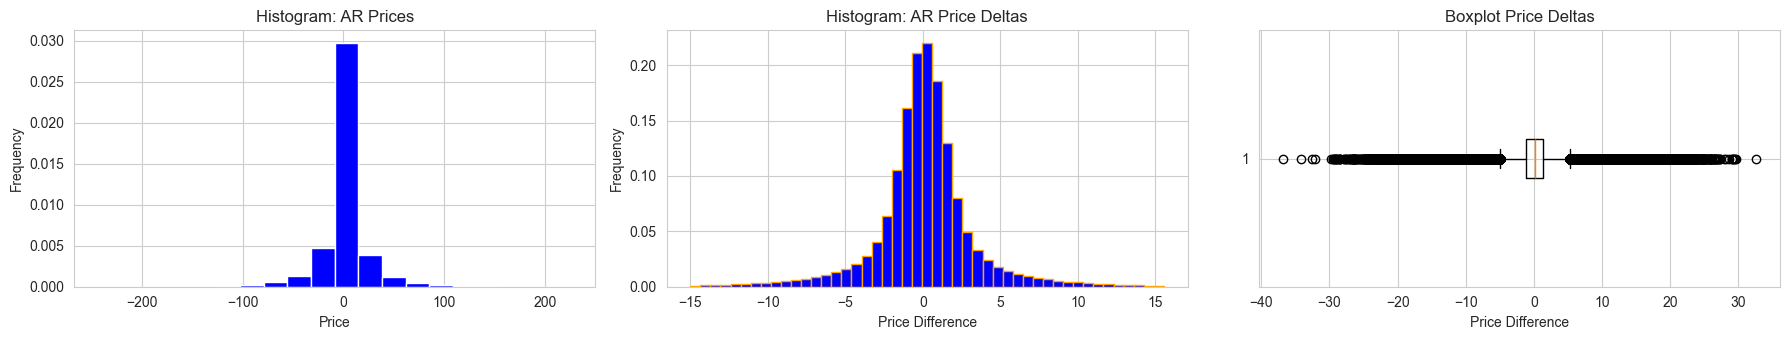

In [ ]:
phi = [0.6, 0.4, 0.3]       # AR coefficients for positive skew    
drift = 0.1                 # Drift term (constant increment per step)
sigma = 1                   # Standard deviation of noise
n_days = 27                 # Length of each sequence
n_sequences = 20000         # Number of Sequences

Price_AR, Delta_AR = ar_p_simulator_with_deltas(n = n_days, m = n_sequences, phi=phi, drift=drift, sigma=sigma)

bin_width = 0.65
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_AR)),3))
print('BIN WIDTH: ', bin_width)

bin_start=-15
bin_stop=15

_, token_size = tokenize_deltas(Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plot_price_hist(Price_AR, Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

In [102]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors"""
    # tokens shape: [batch_size, sequence_length]
    batch_size, seq_length = tokens.shape
    onehot = th.zeros(batch_size, seq_length, vocab_size)
    for i in range(batch_size):
        for j in range(seq_length):
            onehot[i, j, tokens[i, j]] = 1
    return onehot

In [103]:
# Rest of your parameters remain the same
hidden_dim = 256
batch_size = 512
learning_rate = 0.001
seq_len = n_days-1
num_epochs = 50

In [104]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
best_loss = float('inf')
max_grad_norm = 1.0

for epoch in range(num_epochs):
    model_supervised.train()
    temp_loss = []

    # Generate fresh data (this stays the same)
    _, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
    train_data, _ = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

    for batch_idx in range(0, len(train_data), batch_size):
        batch = train_data[batch_idx:batch_idx + batch_size]
        
        # Main changes here: convert inputs to one-hot
        input_tokens = th.tensor(batch[:, :-1], dtype=th.long)  # Changed to long type
        inputs = to_onehot(input_tokens, token_size)  # Convert to one-hot
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.view(-1)
        
        loss = criterion_supervised(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        
        optimizer.step()
        
        temp_loss.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_pretrain_AR.pth')
    
    train_loss.extend(temp_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_loss):.4f}")

Epoch 1/50 - Train Loss: 3.0970
Epoch 2/50 - Train Loss: 2.4885
Epoch 3/50 - Train Loss: 2.2132
Epoch 4/50 - Train Loss: 2.0525
Epoch 5/50 - Train Loss: 2.0083
Epoch 6/50 - Train Loss: 1.9874
Epoch 7/50 - Train Loss: 1.9801
Epoch 8/50 - Train Loss: 1.9744
Epoch 9/50 - Train Loss: 1.9661
Epoch 10/50 - Train Loss: 1.9556
Epoch 11/50 - Train Loss: 1.9430
Epoch 12/50 - Train Loss: 1.9385
Epoch 13/50 - Train Loss: 1.9223
Epoch 14/50 - Train Loss: 1.9234
Epoch 15/50 - Train Loss: 1.9157
Epoch 16/50 - Train Loss: 1.9133
Epoch 17/50 - Train Loss: 1.9097
Epoch 18/50 - Train Loss: 1.9079
Epoch 19/50 - Train Loss: 1.9156
Epoch 20/50 - Train Loss: 1.9024
Epoch 21/50 - Train Loss: 1.9015
Epoch 22/50 - Train Loss: 1.9031
Epoch 23/50 - Train Loss: 1.8997
Epoch 24/50 - Train Loss: 1.9017
Epoch 25/50 - Train Loss: 1.9022
Epoch 26/50 - Train Loss: 1.8973
Epoch 27/50 - Train Loss: 1.8964
Epoch 28/50 - Train Loss: 1.8963
Epoch 29/50 - Train Loss: 1.8967
Epoch 30/50 - Train Loss: 1.8992
Epoch 31/50 - Train

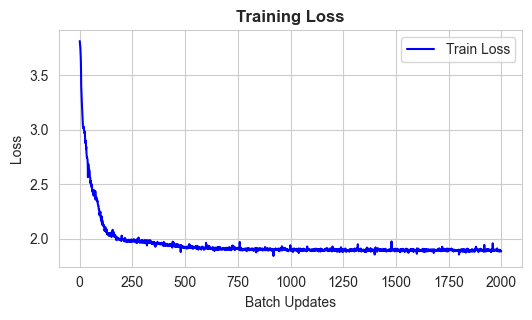

In [105]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Train Loss', color='blue', linewidth=1.5)
plt.title('Training Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

### Supervised Inference

In [ ]:
_, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
test_data, _ = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

# Update model creation to match new architecture
inference_model = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_pretrain_AR.pth', weights_only=False))

test_data_inference = th.tensor(test_data, dtype=th.long)  # Changed to long type

test_losses = []
supervised_data = []

inference_model.eval()

def to_onehot_single(token, vocab_size):
    """Convert single token to one-hot vector"""
    onehot = th.zeros(vocab_size)
    onehot[token.long()] = 1
    return onehot

with th.no_grad():
    for sequence in test_data_inference:
        token_loss = 0
        
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        hidden = None
        
        for i in range(1, len(sequence)):
            # Convert last token to one-hot
            last_token = sim_trajectory[-1]
            input_onehot = to_onehot_single(last_token, token_size).reshape(1, 1, -1)
            
            logits, hidden = inference_model(input_onehot, hidden)
            
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion_supervised(logits.squeeze(1), true_token.long())
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:]) 

supervised_data = np.array(supervised_data)

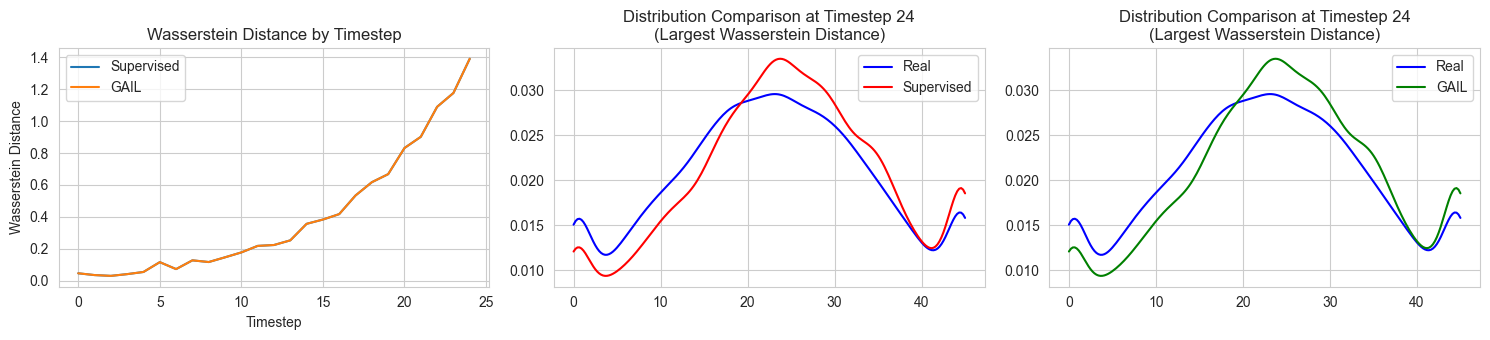

In [107]:
wasserstein_dist(test_data[:,1:], supervised_data, supervised_data)

### GAIL

In [137]:
class LSTM_Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden

In [ ]:
class CustomEnv(gym.Env):
    
    def __init__(self, train_data, bin_start, bin_stop, bin_width, token_size,
                 phi, drift, sigma,
                 discriminator, d_optimizer):
        
        super(CustomEnv, self).__init__()
        
        # Spaces
        self.action_space = spaces.Discrete(token_size)        # Action Space
        self.observation_space = spaces.Discrete(token_size)   # Observation Spacepass

        # Data
        self.seq_gen_len = len(train_data[0]) + 1

        # Bin range and Bin width
        self.num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
        self.bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)
        self.phi = phi
        self.drift = drift
        self.sigma = sigma
        self.ar = np.array([1] + [-coeff for coeff in self.phi])  # AR coefficients with 1 at the beginning
        self.ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])

        # Reset
        self.seq_len = None
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
    
        # Just to compare KL in training
        self.real_train_seq = []
        self.sim_train_seq = []

        # Discriminator
        self.discriminator = discriminator
        self.d_optimizer = d_optimizer
        self.criterion = nn.BCEWithLogitsLoss()

    def step(self, action):

        assert self.action_space.contains(action), "Invalid Action"

        self.seq_position += 1

        self.curr_seq.append(action)

        ###=====REWARD=====###
        reward = self._get_reward(action)
        ###=====REWARD=====###
        
        done = self._is_done()

        if done:            
            self.sim_train_seq.append(self.curr_seq)

        next_obs = action

        return next_obs, reward, done, False, {}        # observation, reward, done, truncated, info

    def get_AR_sequence(self):
        
        arma_process = ArmaProcess(self.ar, self.ma)
        simulated_values = arma_process.generate_sample(nsample=self.seq_gen_len)
        simulated_values += drift * np.arange(self.seq_gen_len)
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        tokenized_data = np.digitize(AR_delta, bins=self.bin_edges, right=False) - 1
        final_seq = np.clip(tokenized_data, 0, self.num_bins - 1)
        return final_seq

    def reset(self, *, seed = None, options = None):

        real_seq = self.get_AR_sequence()

        self.real_train_seq.append(real_seq[1:])
        
        # Reset
        self.seq_len = len(real_seq)
        self.curr_seq = []
        self.seq_position = 0
        self.hidden_states = None
        
        start_token = int(real_seq[0])

        return start_token, {}

    def _is_done(self):

        return self.seq_position == (self.seq_len - 1)

    def _get_reward(self, action):

        self.discriminator.eval()

        with th.no_grad():
            temp_action = th.tensor(np.array([[action]]), dtype=th.long)
            prediction, self.hidden_states = self.discriminator(temp_action, self.hidden_states)
            prediction = prediction[0,0]
            label = th.ones_like(prediction)
            seq_loss = self.criterion(prediction, label)
            reward = -(seq_loss.item())
            return reward

    def clear_rollout_seq(self):
        self.real_train_seq = []
        self.sim_train_seq = []

    def calculate_kl_div(self):

        real_counts = Counter(np.concatenate(self.real_train_seq))
        fake_counts = Counter(np.concatenate(self.sim_train_seq))
        
        total_real = len(np.concatenate(self.real_train_seq))
        total_fake = len(np.concatenate(self.sim_train_seq))
        
        real_probs = {token: count/total_real for token, count in real_counts.items()}
        fake_probs = {token: count/total_fake for token, count in fake_counts.items()}

        eps = 1e-10  # Small constant for numerical stability
        kl = 0
        for token, p_real in real_probs.items():
            p_fake = fake_probs.get(token, eps)
            if p_real > 0:  # Only compute for non-zero probabilities
                kl += p_real * np.log2(max(p_real, eps) / max(p_fake, eps))
        
        return kl

    def calculate_wasserstein_distance(self):

        real_sequences = np.array(self.real_train_seq)
        generated_sequences = np.array(self.sim_train_seq)
        
        wasserstein_distances = []
        for i in range(len(self.real_train_seq[0])):
            w_dist = wasserstein_distance(real_sequences[:, i], generated_sequences[:, i])
            wasserstein_distances.append(w_dist)

        # Different ways to analyze the results
        return np.mean(wasserstein_distances)  # Overall performance

    def discriminator_accuracy(self, real_data, fake_data):

        self.discriminator.eval()
        
        with th.no_grad():
            batch_real = th.tensor(real_data, dtype=th.long)
            batch_fake = th.tensor(fake_data, dtype=th.long)
            
            # Get sequence length and split point
            seq_len = batch_real.size(1)  # Assuming shape is [batch_size, seq_len]
            split_idx = seq_len // 2
            
            # Split real sequences
            real_first_half = batch_real[:, :split_idx]
            real_second_half = batch_real[:, split_idx:]
            
            # Split fake sequences
            fake_first_half = batch_fake[:, :split_idx]
            fake_second_half = batch_fake[:, split_idx:]
            
            # First half accuracy
            real_preds_first, _ = self.discriminator(real_first_half, None)
            fake_preds_first, _ = self.discriminator(fake_first_half, None)
            
            real_probs_first = th.sigmoid(real_preds_first)
            fake_probs_first = th.sigmoid(fake_preds_first)
            
            correct_real_first = (real_probs_first > 0.5).float().sum()
            correct_fake_first = (fake_probs_first < 0.5).float().sum()
            
            total_samples_first = real_probs_first.numel() + fake_probs_first.numel()
            accuracy_first = (correct_real_first + correct_fake_first) / total_samples_first
            
            # Second half accuracy
            real_preds_second, _ = self.discriminator(real_second_half, None)
            fake_preds_second, _ = self.discriminator(fake_second_half, None)
            
            real_probs_second = th.sigmoid(real_preds_second)
            fake_probs_second = th.sigmoid(fake_preds_second)
            
            correct_real_second = (real_probs_second > 0.5).float().sum()
            correct_fake_second = (fake_probs_second < 0.5).float().sum()
            
            total_samples_second = real_probs_second.numel() + fake_probs_second.numel()
            accuracy_second = (correct_real_second + correct_fake_second) / total_samples_second
            
        return accuracy_first.item(), accuracy_second.item()

    def discriminator_accuracy_(self, real_data, fake_data):
            
            self.discriminator.eval()

            with th.no_grad():
                
                batch_real = th.tensor(real_data, dtype=th.long)
                batch_fake = th.tensor(fake_data, dtype=th.long)

                # Real data
                real_preds, _ = self.discriminator(batch_real, None)
                real_probs = th.sigmoid(real_preds)
                
                # Fake data
                fake_preds, _ = self.discriminator(batch_fake, None)
                fake_probs = th.sigmoid(fake_preds)

                correct_real = (real_probs > 0.5).float().sum()
                correct_fake = (fake_probs < 0.5).float().sum()
                
                # Total samples
                total_samples = real_probs.numel() + fake_probs.numel()
                
                # Overall accuracy
                accuracy = (correct_real + correct_fake) / total_samples
            
            return accuracy.item()

    def discriminator_loss(self, real_data, fake_data):

        self.discriminator.eval()  # Set to evaluation mode

        with th.no_grad():
            batch_real = th.tensor(real_data, dtype=th.long)
            batch_fake = th.tensor(fake_data, dtype=th.long)
            
            # Real data
            real_preds, _ = self.discriminator(batch_real, None)
            real_preds = real_preds.view(-1)
            real_labels = th.ones_like(real_preds)
            real_loss = self.criterion(real_preds, real_labels)
            
            # Fake data
            fake_preds, _ = self.discriminator(batch_fake, None)
            fake_preds = fake_preds.view(-1)
            fake_labels = th.zeros_like(fake_preds)
            fake_loss = self.criterion(fake_preds, fake_labels)
            
            # Average loss
            d_loss = (real_loss + fake_loss) / 2

            return d_loss

    def train_discriminator(self):
        
        discriminator_loss = []
        discriminator_accuracy = []
        discriminator_accuracy_1 = []
        discriminator_accuracy_2 = []


        # Convert to arrays once at the start
        real_sequences = np.array(self.real_train_seq)
        fake_sequences = np.array(self.sim_train_seq)

        # Get initial metrics
        pre_accuracy_1,  pre_accuracy_2 = self.discriminator_accuracy(real_sequences, fake_sequences)
        pre_accuracy = (pre_accuracy_1 + pre_accuracy_2)/2
        pre_accuracy_diff = np.diff([pre_accuracy_1, pre_accuracy_2]).item()

        discr_loss = self.discriminator_loss(real_sequences, fake_sequences)
        
        # Adaptive updates based on performance
        d_loss_threshold = 0.6
        min_d_updates = 5
        max_d_updates = 5
        d_updates = max_d_updates if discr_loss > d_loss_threshold else min_d_updates

        self.discriminator.train()

        # Calculate batch size - consider adding this
        batch_size = min(256, len(fake_sequences))  # Reasonable batch size

        current_accuracy = (pre_accuracy_1 + pre_accuracy_2)/2
        
        early_stop_acc = 0.80

        for _ in range(d_updates):
            
            # Early Stopping
            if current_accuracy > early_stop_acc:
                break

            # Create mini-batches
            indices = th.randperm(len(fake_sequences))[:batch_size]  # Use only batch_size samples
            batch_real = th.tensor(real_sequences[indices], dtype=th.long)
            batch_fake = th.tensor(fake_sequences[indices], dtype=th.long)
            
            # Forward pass - real data
            real_preds, _ = self.discriminator(batch_real, None)
            real_preds = real_preds.view(-1)
            real_labels = th.ones_like(real_preds) * 0.9  # Label smoothing
            real_loss = self.criterion(real_preds, real_labels)
            
            # Forward pass - fake data
            fake_preds, _ = self.discriminator(batch_fake, None)
            fake_preds = fake_preds.view(-1)
            fake_labels = th.ones_like(fake_preds) * 0.1  # Label smoothing
            fake_loss = self.criterion(fake_preds, fake_labels)
            
            # Combined loss and update
            d_loss = (real_loss + fake_loss) / 2
            self.d_optimizer.zero_grad()
            d_loss.backward()
            th.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)  # Add gradient clipping
            self.d_optimizer.step()
            
            # Track metrics
            with th.no_grad():  # Add no_grad for efficiency
                pre_accuracy_1,  pre_accuracy_2 = self.discriminator_accuracy(real_sequences, fake_sequences)
                current_accuracy = (pre_accuracy_1 + pre_accuracy_2)/2
                discriminator_accuracy.append(current_accuracy)
                discriminator_accuracy_1.append(pre_accuracy_1)
                discriminator_accuracy_2.append(pre_accuracy_2)
                discriminator_loss.append(d_loss.item())

        post_accuracy_1, post_accuracy_2 = self.discriminator_accuracy(real_sequences, fake_sequences)
        post_accuracy = (post_accuracy_1+post_accuracy_2)/2
        post_accuracy_diff = np.diff([post_accuracy_1, post_accuracy_2]).item()

        return discriminator_loss, discriminator_accuracy_1, discriminator_accuracy_2, pre_accuracy, post_accuracy, pre_accuracy_diff, post_accuracy_diff


In [181]:
class CustomCallback(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: (int) Verbosity level 0: not output 1: info 2: debug

    Those variables will be accessible in the callback
    (they are defined in the base class)
    The RL model
    self.model = None  # type: BaseRLModel
    An alias for self.model.get_env(), the environment used for training
    self.training_env = None  # type: Union[gym.Env, VecEnv, None]
    Number of time the callback was called
    self.n_calls = 0  # type: int
    self.num_timesteps = 0  # type: int
    local and global variables
    self.locals = None  # type: Dict[str, Any]
    self.globals = None  # type: Dict[str, Any]
    The logger object, used to report things in the terminal
    self.logger = None  # type: logger.Logger
    # Sometimes, for event callback, it is useful
    # to have access to the parent object
    self.parent = None  # type: Optional[BaseCallback]

    train/learning_rate
    train/entropy_loss
    train/policy_gradient_loss
    train/value_loss
    train/approx_kl
    train/clip_fraction
    train/loss
    train/explained_variance
    train/n_updates
    train/clip_range
    """
    
    def __init__(self, verbose, display_rollout):
        
        super(CustomCallback, self).__init__(verbose)
        
        # Display Rollout
        self.display_rollout = display_rollout
        # Losses
        self.pg_losses, self.value_losses, self.entropy_losses = [], [], []
        # Rewards
        self.rewards = []
        # KL Div
        self.kl_div = []
        # Wasserstein
        self.wasserstein = []
        
        # Discriminator
        self.discriminator_loss = []
        self.discriminator_accuracy_1 = []
        self.discriminator_accuracy_2 = []
        self.d_pre_acc = []
        self.d_post_acc = []
        self.d_pre_acc_diff = []
        self.d_post_acc_diff = []

        self.best_wasserstein = float('inf')  # Initialize with infinity
        self.best_model_path = "best_model_AR"   # Path to save best model

    def _on_training_start(self) -> None:
        
        pass

    def _on_rollout_start(self) -> None:
        
        self.save_losses()

    def _on_step(self) -> bool:

        return True

    def _on_rollout_end(self) -> None:

        if self.display_rollout:
            self.display_rollout_buffer()
        
        self.save_reward()

        ## NEED TO ADJUST FOR MULTIPLE ENVIRONMENTS
        for env in self.training_env.envs:
            
            # Calculate KL Div.
            curr_kl =  env.unwrapped.calculate_kl_div()

            # Calculate Wasserstein Distance
            wasser_dis = env.unwrapped.calculate_wasserstein_distance()
            
            # Train Discriminator            
            d_train_loss, d_train_acc_1, d_train_acc_2, pre_accuracy, post_accuracy, pre_accuracy_diff, post_accuracy_diff = env.unwrapped.train_discriminator()
            
            # Reset Lists
            env.unwrapped.clear_rollout_seq()
        
        # Save model if we have a new best Wasserstein distance
        if wasser_dis < self.best_wasserstein:
            self.best_wasserstein = wasser_dis
            print(f"\nNew best Wasserstein distance: {wasser_dis:.3f}, saving model...")
            self.model.save(f"{self.best_model_path}")
        
        self.kl_div.append(curr_kl)
        self.wasserstein.append(wasser_dis)
        self.discriminator_loss.extend(d_train_loss)
        self.discriminator_accuracy_1.extend(d_train_acc_1)
        self.discriminator_accuracy_2.extend(d_train_acc_2)
        self.d_pre_acc.append(pre_accuracy)
        self.d_post_acc.append(post_accuracy)
        self.d_pre_acc_diff.append(pre_accuracy_diff)
        self.d_post_acc_diff.append(post_accuracy_diff)

        print(f"Wasserstein: {self.wasserstein[-1]:.3f} - Pre Accuracy: {self.d_pre_acc[-1]:.3f} - Post Accuracy: {self.d_post_acc[-1]:.3f} - Pre Acc Diff: {self.d_pre_acc_diff[-1]:.3f} - Post Acc Diff: {self.d_post_acc_diff[-1]:.3f}")

    def _on_training_end(self) -> None:
        
        self.save_losses()

    def save_losses(self) -> None:
        self.pg_losses.append(self.logger.name_to_value.get('train/policy_gradient_loss', None))
        self.value_losses.append(self.logger.name_to_value.get('train/value_loss', None))
        self.entropy_losses.append(self.logger.name_to_value.get('train/entropy_loss', None))

    def display_rollout_buffer(self):
        print("\nRollout Buffer Contents:")
        
        # Get original shaped arrays
        observations = self.model.rollout_buffer.observations  # Shape: (n_steps, n_envs)
        actions = self.model.rollout_buffer.actions
        rewards = self.model.rollout_buffer.rewards
        returns = self.model.rollout_buffer.returns
        episode_starts = self.model.rollout_buffer.episode_starts
        values = self.model.rollout_buffer.values
        log_probs = self.model.rollout_buffer.log_probs
        advantages = self.model.rollout_buffer.advantages
        
        # Print header with line
        header = "  env_id    step    observations  actions  rewards  returns  episode_starts  values  log_probs  advantages"
        print("-" * (len(header) + 5))
        print(header)
        print("-" * (len(header) + 5))
        
        # For each environment
        for env_idx in range(self.training_env.num_envs):
            # Get data for this environment
            env_obs = observations[:, env_idx]
            env_actions = actions[:, env_idx]
            env_rewards = rewards[:, env_idx]
            env_returns = returns[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            env_values = values[:, env_idx]
            env_log_probs = log_probs[:, env_idx]
            env_advantages = advantages[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            
            # Print rows for this environment
            last_idx = -1
            for step in range(len(env_obs)):
                if step in ep_start_idx:
                    if last_idx != -1:
                        print("=" * (len(header) + 5))
                    print(f"Environment {env_idx} - New Episode")
                    print("-" * (len(header) + 5))
                
                # Convert arrays to strings or get first element if array
                obs_str = str(env_obs[step].item()) if hasattr(env_obs[step], 'item') else str(env_obs[step])
                action_str = str(env_actions[step].item()) if hasattr(env_actions[step], 'item') else str(env_actions[step])
                
                print(
                    f"Obs: {obs_str:8s}  "
                    f"Act: {action_str:4s}  "
                    f"Rew: {env_rewards[step]:6.2f}  "
                    f"Ret: {env_returns[step]:7.2f}  "
                    f"Start: {int(env_starts[step]):1d}  "
                    f"Val: {env_values[step]:6.2f}  "
                    f"LogP: {env_log_probs[step]:8.2f}  "
                    f"Adv: {env_advantages[step]:8.2f}")
                
                last_idx = step
            
            print("=" * (len(header) + 5))
            print(f"End of Environment {env_idx}")
            print("\n")

    def save_reward(self):
        # Get rewards without reshaping
        rewards = self.model.rollout_buffer.rewards  # Shape: (n_steps, n_envs)
        episode_starts = self.model.rollout_buffer.episode_starts
        
        all_sequence_rewards = []
        
        # Process each environment separately
        for env_idx in range(self.training_env.num_envs):
            # Get rewards and episode starts for this environment
            env_rewards = rewards[:, env_idx]
            env_starts = episode_starts[:, env_idx]
            
            # Find episode starts for this env
            ep_start_idx = np.where(env_starts)[0]
            if not env_starts[0]:
                ep_start_idx = np.r_[0, ep_start_idx]
                
            # Calculate rewards for this env's sequences
            sequence_rewards = np.add.reduceat(env_rewards, np.r_[0, ep_start_idx[1:]])
            all_sequence_rewards.extend(sequence_rewards)
        
        # Store average across all envs
        self.rewards.append(np.mean(all_sequence_rewards))


In [206]:
discriminator = LSTM_Discriminator(vocab_size=token_size, embedding_dim=32, hidden_dim=256)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4, betas=(0.5, 0.999))

env_test = CustomEnv(train_data=train_data, bin_start=bin_start, bin_stop=bin_stop, 
                     bin_width=bin_width, token_size=token_size,
                     phi=phi, drift=drift, sigma=sigma, 
                     discriminator=discriminator, d_optimizer=d_optimizer)

env_test = Monitor(env_test, filename=None) 

model_test = RecurrentPPO(
    policy='MlpLstmPolicy',
    env=env_test,
    verbose=0,
    
    # Shorter episodes for more frequent updates
    n_steps=400*25,
    batch_size=8*25,
    n_epochs=15,

    clip_range=0.15,
    ent_coef=0.02,
    
    learning_rate=linear_schedule(2e-4),       
    
    # Adjust value estimation
    vf_coef=0.80,            
    gamma=0.995,
    gae_lambda=0.96,
    
    
    policy_kwargs=dict(
        lstm_hidden_size=256,
        n_lstm_layers=2,
        net_arch=dict(pi=[], vf=[]),
        shared_lstm=True,  # Use shared LSTM
        enable_critic_lstm=False,  # Disable separate critic LSTM
    )
)

callback_test = CustomCallback(verbose=0, display_rollout=False)

In [207]:
model_test.learn(500000, callback=callback_test)
env_test.close()


New best Wasserstein distance: 7.917, saving model...
Wasserstein: 7.917 - Pre Accuracy: 0.501 - Post Accuracy: 0.809 - Pre Acc Diff: 0.000 - Post Acc Diff: -0.117
Wasserstein: 8.214 - Pre Accuracy: 0.828 - Post Accuracy: 0.828 - Pre Acc Diff: -0.112 - Post Acc Diff: -0.112
Wasserstein: 8.324 - Pre Accuracy: 0.823 - Post Accuracy: 0.823 - Pre Acc Diff: -0.095 - Post Acc Diff: -0.095
Wasserstein: 8.570 - Pre Accuracy: 0.823 - Post Accuracy: 0.823 - Pre Acc Diff: -0.101 - Post Acc Diff: -0.101
Wasserstein: 8.165 - Pre Accuracy: 0.816 - Post Accuracy: 0.816 - Pre Acc Diff: -0.092 - Post Acc Diff: -0.092
Wasserstein: 8.049 - Pre Accuracy: 0.794 - Post Accuracy: 0.814 - Pre Acc Diff: -0.138 - Post Acc Diff: -0.146
Wasserstein: 8.024 - Pre Accuracy: 0.817 - Post Accuracy: 0.817 - Pre Acc Diff: -0.116 - Post Acc Diff: -0.116

New best Wasserstein distance: 7.885, saving model...
Wasserstein: 7.885 - Pre Accuracy: 0.806 - Post Accuracy: 0.806 - Pre Acc Diff: -0.149 - Post Acc Diff: -0.149
Was

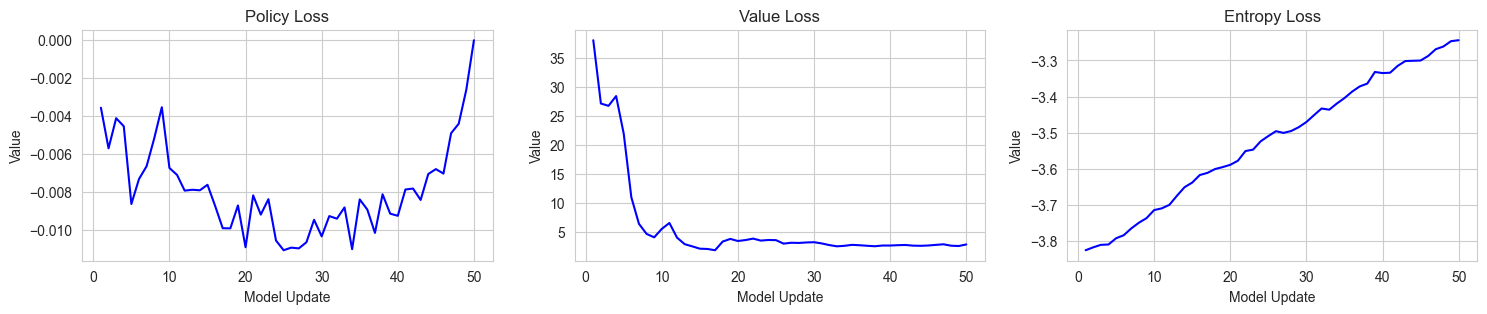

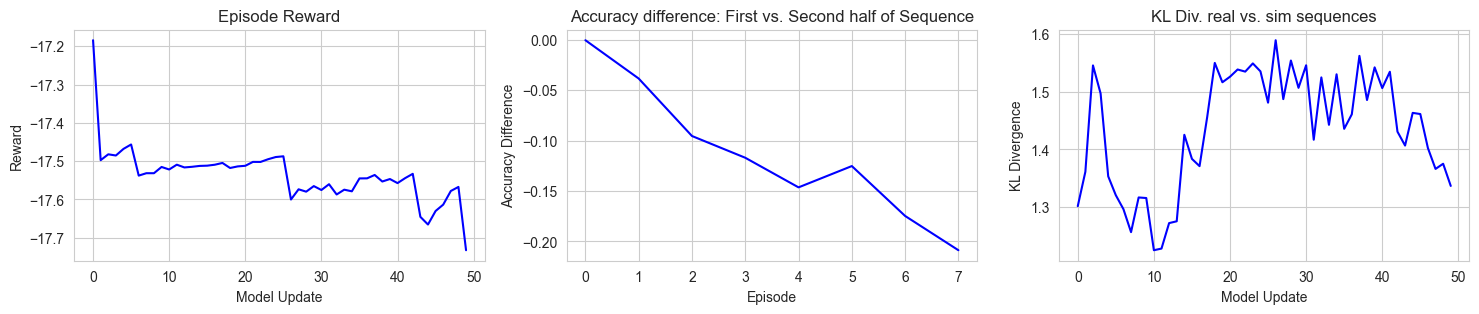

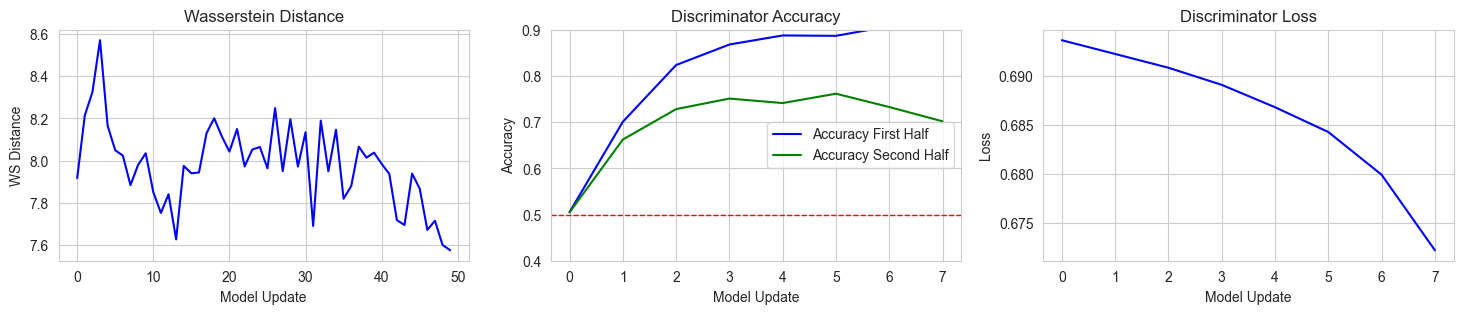

In [208]:
plot_losses(pg_loss=callback_test.pg_losses,
            value_loss=callback_test.value_losses,
            entropy_loss=callback_test.entropy_losses)

plot_rewards(ep_rew=callback_test.rewards,
             acc_diff=np.subtract(callback_test.discriminator_accuracy_2,callback_test.discriminator_accuracy_1),
             kl_div=callback_test.kl_div)

plot_discriminator(wasserstein=callback_test.wasserstein,
                   disc_acc_1=callback_test.discriminator_accuracy_1,
                   disc_acc_2=callback_test.discriminator_accuracy_2,
                   disc_loss=callback_test.discriminator_loss)

In [121]:
model_new = transfer_weights_from_saved('supervised_pretrain_AR.pth', model_test, True, token_size, hidden_dim, token_size)

Loaded saved supervised weights successfully

=== Transferring LSTM Weights ===

Weight shapes before transfer:

Supervised LSTM weights:
lstm.weight_ih_l0: torch.Size([1024, 46])
lstm.weight_hh_l0: torch.Size([1024, 256])
lstm.bias_ih_l0: torch.Size([1024])
lstm.bias_hh_l0: torch.Size([1024])
lstm.weight_ih_l1: torch.Size([1024, 256])
lstm.weight_hh_l1: torch.Size([1024, 256])
lstm.bias_ih_l1: torch.Size([1024])
lstm.bias_hh_l1: torch.Size([1024])

PPO LSTM weights:
weight_ih_l0: torch.Size([1024, 46])
weight_hh_l0: torch.Size([1024, 256])
bias_ih_l0: torch.Size([1024])
bias_hh_l0: torch.Size([1024])
weight_ih_l1: torch.Size([1024, 256])
weight_hh_l1: torch.Size([1024, 256])
bias_ih_l1: torch.Size([1024])
bias_hh_l1: torch.Size([1024])
Transferred weights for weight_ih_l0
Transferred weights for weight_hh_l0
Transferred weights for bias_ih_l0
Transferred weights for bias_hh_l0
Transferred weights for weight_ih_l1
Transferred weights for weight_hh_l1
Transferred weights for bias_ih_l1


/var/folders/1x/hjv8bl714_xgsbdy8fp5kj140000gn/T/ipykernel_10239/2786929323.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_weights = th.load(weights_path)


In [127]:
gail_data = []

for sequence in test_data:
    
    _, _ = env_test.reset()
    done = False
    curr_seq_sim  = []
    action = sequence[0]

    lstm_states = None
    num_envs = 1
    episode_starts = np.ones((num_envs,), dtype=bool)

    while not done:
        action, lstm_states = model_new.predict(action, state=lstm_states, episode_start=episode_starts, deterministic=False)
        _, _, done, _, _ = env_test.step(action)
        episode_starts = done
        curr_seq_sim.append(action.item())
    
    gail_data.append(curr_seq_sim)

gail_data = np.array(gail_data)


In [132]:
def wasserstein_dist_dummy(real_sequences, supervised, gail):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    wasserstein_gail = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], gail[:, t])
        wasserstein_gail.append(w_dist)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 3)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.plot(wasserstein_gail, label = 'Supervised')
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_sequences[:, 0]
    generated_data = supervised[:, 0]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {0}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()

    # Plot 3: Compare specific timesteps
    ax3 = fig.add_subplot(gs[0, 2])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_gail = np.argmax(wasserstein_gail)

    # Get data for the specified timestep
    real_data = real_sequences[:, 0]
    generated_data = gail[:, 0]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax3.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax3.plot(x_eval, kde_generated(x_eval), label='GAIL', color='green')
    ax3.set_title(f'Distribution Comparison at Timestep {0}\n'
                f'(Largest Wasserstein Distance)')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

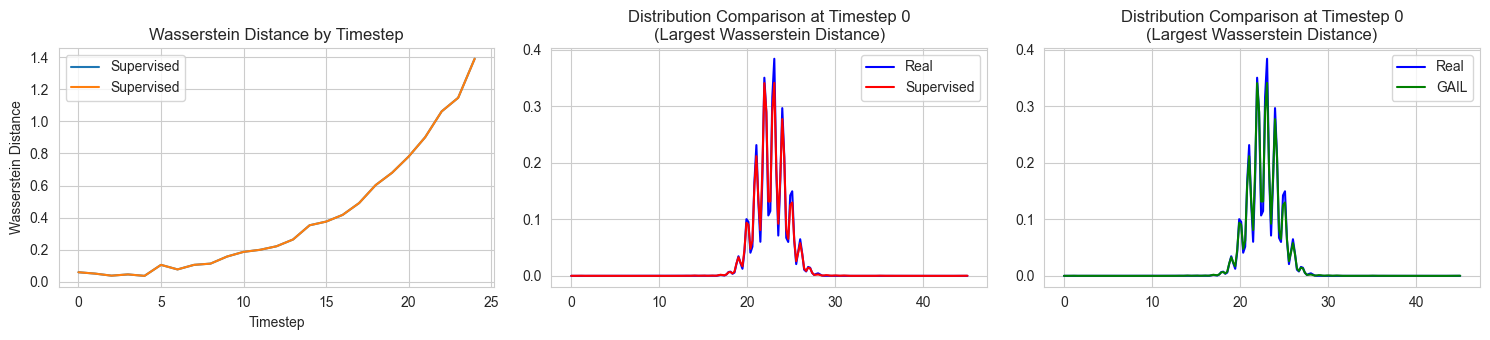

In [133]:
wasserstein_dist_dummy(test_data[:,1:], gail_data, gail_data)

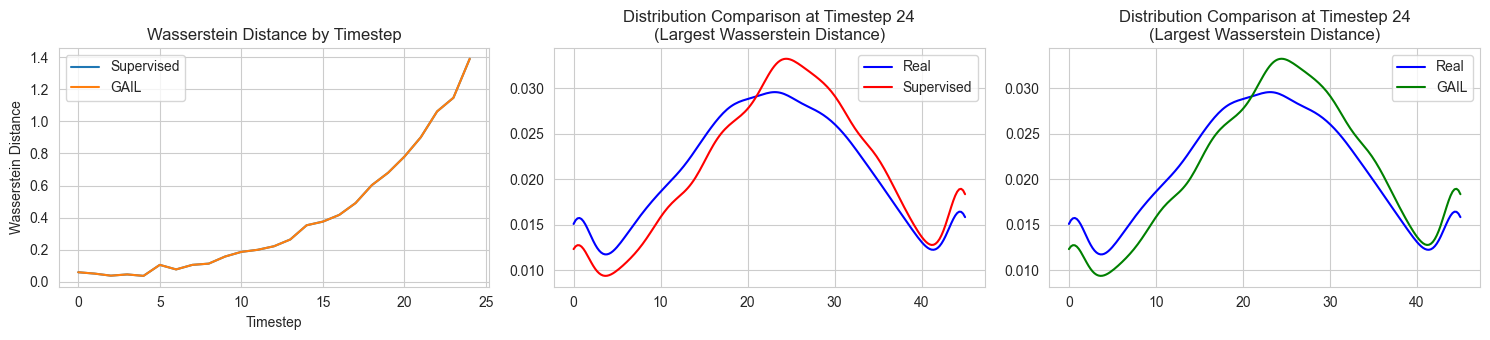

In [131]:
wasserstein_dist(test_data[:,1:], gail_data, gail_data)

In [110]:
print("\nSupervised LSTM Architecture:")
print(model_supervised)


Supervised LSTM Architecture:
LSTMModel(
  (lstm): LSTM(46, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=46, bias=True)
)


In [112]:
print("\nPPO Model Architecture:")
print(model_test.policy)


PPO Model Architecture:
RecurrentActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential()
    (value_net): Sequential()
  )
  (action_net): Linear(in_features=256, out_features=46, bias=True)
  (value_net): Linear(in_features=256, out_features=1, bias=True)
  (lstm_actor): LSTM(46, 256, num_layers=2)
)


In [201]:
dummy_disc = LSTM_Discriminator(vocab_size=token_size, embedding_dim=32, hidden_dim=256)
dummy_optimizer = optim.Adam(dummy_disc.parameters(), lr=2e-4)
dummy_criterion = nn.BCEWithLogitsLoss()

dummy_loss = []
dummy_acc_1 = []
dummy_acc_2 = []

dummy_batch_size = 128

n_dummy_seq = 128*100

# Convert to arrays once at the start
dummy_real = np.array(test_data[:n_dummy_seq,1:])
dummy_fake = np.array(supervised_data[:n_dummy_seq])
seq_length = dummy_real.shape[1]

dummy_epochs = 2

for epoch in range(dummy_epochs):
            
    dummy_temp_loss = []
    dummy_temp_acc_first_half = []
    dummy_temp_acc_second_half = []
 
    indices = np.arange(n_dummy_seq)
    np.random.shuffle(indices)

    for batch_idx in range(0, n_dummy_seq, dummy_batch_size):
        
                    
        dummy_disc.train()
        batch_indices = indices[batch_idx:batch_idx + batch_size]

        batch_real = th.tensor(dummy_real[batch_indices], dtype=th.long)
        batch_fake = th.tensor(dummy_fake[batch_indices], dtype=th.long)
                    
        # Forward pass - real data
        real_preds, _ = dummy_disc(batch_real, None)
        real_preds = real_preds.view(-1)
        real_labels = th.ones_like(real_preds) * 0.9  # Label smoothing
        real_loss = dummy_criterion(real_preds, real_labels)
                    
        # Forward pass - fake data
        fake_preds, _ = dummy_disc(batch_fake, None)
        fake_preds = fake_preds.view(-1)
        fake_labels = th.ones_like(fake_preds) * 0.1  # Label smoothing
        fake_loss = dummy_criterion(fake_preds, fake_labels)
                    
        # Combined loss and update
        d_loss = (real_loss + fake_loss) / 2
        dummy_optimizer.zero_grad()
        d_loss.backward()
        th.nn.utils.clip_grad_norm_(dummy_disc.parameters(), max_norm=1.0)
        dummy_optimizer.step()


        dummy_disc.eval()    
        # Track metrics

        with th.no_grad():
            # Get predictions
            real_preds, _ = dummy_disc(batch_real, None)
            real_probs = th.sigmoid(real_preds)
            fake_preds, _ = dummy_disc(batch_fake, None)
            fake_probs = th.sigmoid(fake_preds)
            
            # Reshape probabilities to [batch_size, seq_length]
            real_probs_reshaped = real_probs.view(-1, seq_length)
            fake_probs_reshaped = fake_probs.view(-1, seq_length)
            
            # Split point for first/second half
            split_idx = seq_length // 2
            
            # First half accuracy
            real_probs_first = real_probs_reshaped[:, :split_idx]
            fake_probs_first = fake_probs_reshaped[:, :split_idx]
            correct_real_first = (real_probs_first > 0.5).float().sum()
            correct_fake_first = (fake_probs_first < 0.5).float().sum()
            total_samples_first = real_probs_first.numel() + fake_probs_first.numel()
            accuracy_first_half = (correct_real_first + correct_fake_first) / total_samples_first
            
            # Second half accuracy
            real_probs_second = real_probs_reshaped[:, split_idx:]
            fake_probs_second = fake_probs_reshaped[:, split_idx:]
            correct_real_second = (real_probs_second > 0.5).float().sum()
            correct_fake_second = (fake_probs_second < 0.5).float().sum()
            total_samples_second = real_probs_second.numel() + fake_probs_second.numel()
            accuracy_second_half = (correct_real_second + correct_fake_second) / total_samples_second
            
            # Store results
            dummy_temp_loss.append(d_loss.item())
            dummy_temp_acc_first_half.append(accuracy_first_half.item())
            dummy_temp_acc_second_half.append(accuracy_second_half.item())

    
    dummy_loss.extend(dummy_temp_loss)
    dummy_acc_1.extend(dummy_temp_acc_first_half)
    dummy_acc_2.extend(dummy_temp_acc_second_half)

    print(f"Epoch {epoch+1}/{dummy_epochs} - Train Loss: {np.mean(dummy_temp_loss):.4f} - Full Accuracy: {np.mean(dummy_temp_acc):.4f} - Late Accuracy: {np.mean(dummy_temp_acc_late):.4f}")

Epoch 1/2 - Train Loss: 0.6922 - Full Accuracy: 0.5381 - Late Accuracy: 0.5705
Epoch 2/2 - Train Loss: 0.6917 - Full Accuracy: 0.5381 - Late Accuracy: 0.5705


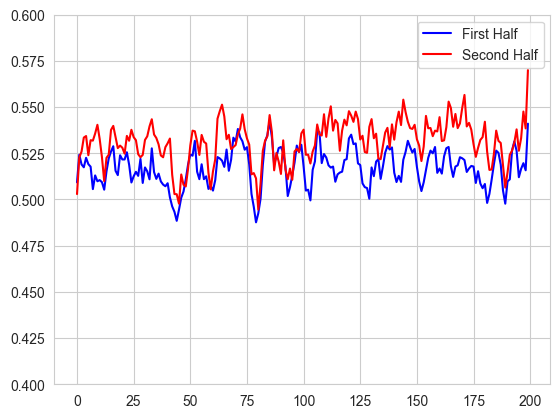

In [202]:
#plt.plot(dummy_loss, label='Loss', color='green')
plt.plot(dummy_acc_1, label='First Half', color='blue')
plt.plot(dummy_acc_2, label='Second Half', color='red')
plt.ylim(0.4,0.6)

plt.legend()
plt.show()

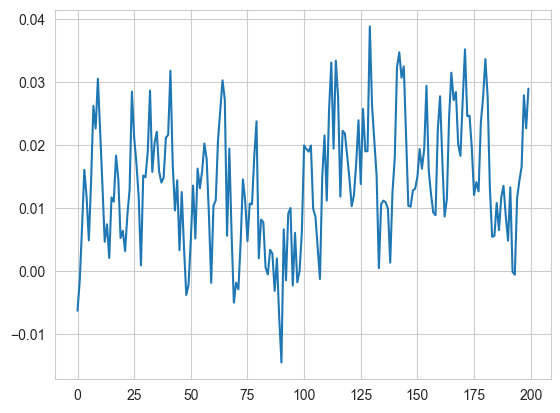

In [203]:
plt.plot(np.subtract(dummy_acc_2,dummy_acc_1))
plt.show()

In [204]:
dummy_disc = LSTM_Discriminator(vocab_size=token_size, embedding_dim=64, hidden_dim=512)
dummy_optimizer = optim.Adam(dummy_disc.parameters(), lr=2e-4)
dummy_criterion = nn.BCEWithLogitsLoss()

dummy_loss = []
dummy_acc = []
dummy_acc_late = []

dummy_batch_size = 128

n_dummy_seq = 128*100

# Convert to arrays once at the start
dummy_real = np.array(test_data[:n_dummy_seq,1:])
dummy_fake = np.array(supervised_data[:n_dummy_seq])

dummy_epochs = 1

for epoch in range(dummy_epochs):
    dummy_temp_loss = []
    dummy_temp_acc = []
    dummy_temp_acc_late = []
 
    indices = np.arange(n_dummy_seq)
    np.random.shuffle(indices)

    for batch_idx in range(0, n_dummy_seq, dummy_batch_size):
        dummy_disc.train()
        batch_indices = indices[batch_idx:batch_idx + batch_size]

        batch_real = th.tensor(dummy_real[batch_indices], dtype=th.long)
        batch_fake = th.tensor(dummy_fake[batch_indices], dtype=th.long)
                    
        # Forward pass - real data
        real_preds, _ = dummy_disc(batch_real, None)
        real_preds = real_preds.view(-1, seq_length)
        real_preds = real_preds[:, 15:]  # Only consider later timesteps
        real_labels = th.ones_like(real_preds) * 0.9
        real_loss = dummy_criterion(real_preds, real_labels)
                    
        # Forward pass - fake data
        fake_preds, _ = dummy_disc(batch_fake, None)
        fake_preds = fake_preds.view(-1, seq_length)
        fake_preds = fake_preds[:, 15:]  # Only consider later timesteps
        fake_labels = th.ones_like(fake_preds) * 0.1
        fake_loss = dummy_criterion(fake_preds, fake_labels)
                    
        # Combined loss and update
        d_loss = (real_loss + fake_loss) / 2
        dummy_optimizer.zero_grad()
        d_loss.backward()
        th.nn.utils.clip_grad_norm_(dummy_disc.parameters(), max_norm=1.0)
        dummy_optimizer.step()

        dummy_disc.eval()    
        # Track metrics
        with th.no_grad():
            # Real data
            real_preds, _ = dummy_disc(batch_real, None)
            real_probs = th.sigmoid(real_preds)
                
            # Fake data
            fake_preds, _ = dummy_disc(batch_fake, None)
            fake_probs = th.sigmoid(fake_preds)

            # Full sequence accuracy
            correct_real = (real_probs > 0.5).float().sum()
            correct_fake = (fake_probs < 0.5).float().sum()
            total_samples = real_probs.numel() + fake_probs.numel()
            accuracy_full = (correct_real + correct_fake) / total_samples

            # Late steps accuracy (after step 15)
            real_probs_late = real_probs.view(-1, seq_length)[:, 15:]
            fake_probs_late = fake_probs.view(-1, seq_length)[:, 15:]
            
            correct_real_late = (real_probs_late > 0.5).float().sum()
            correct_fake_late = (fake_probs_late < 0.5).float().sum()
            total_samples_late = real_probs_late.numel() + fake_probs_late.numel()
            accuracy_late = (correct_real_late + correct_fake_late) / total_samples_late
        
            dummy_temp_loss.append(d_loss.item())
            dummy_temp_acc.append(accuracy_full.item())
            dummy_temp_acc_late.append(accuracy_late.item())
    
    dummy_loss.extend(dummy_temp_loss)
    dummy_acc.extend(dummy_temp_acc)
    dummy_acc_late.extend(dummy_temp_acc_late)

    print(f"Epoch {epoch+1}/{dummy_epochs} - Train Loss: {np.mean(dummy_temp_loss):.4f} - Full Accuracy: {np.mean(dummy_temp_acc):.4f} - Late Accuracy: {np.mean(dummy_temp_acc_late):.4f}")

Epoch 1/1 - Train Loss: 0.6915 - Full Accuracy: 0.5228 - Late Accuracy: 0.5312


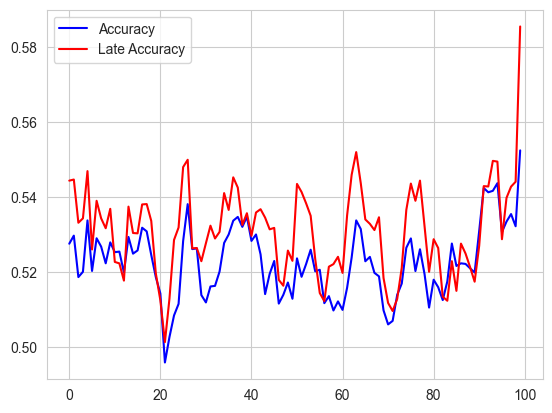

In [205]:
#plt.plot(dummy_loss, label='Loss', color='green')
plt.plot(dummy_acc, label='Accuracy', color='blue')
plt.plot(dummy_acc_late, label='Late Accuracy', color='red')

plt.legend()
plt.show()

In [209]:
def wasserstein_dist_old(real_sequences, supervised):

    n_timesteps = real_sequences.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []

    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_sequences[:, t], supervised[:, t])
        wasserstein_supervised.append(w_dist)
    
    
    # Create visualization
    fig = plt.figure(figsize=(6, 4))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 1)
    
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "AR MODEL")
    ax1.legend()
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    
    
    plt.tight_layout()
    plt.show()

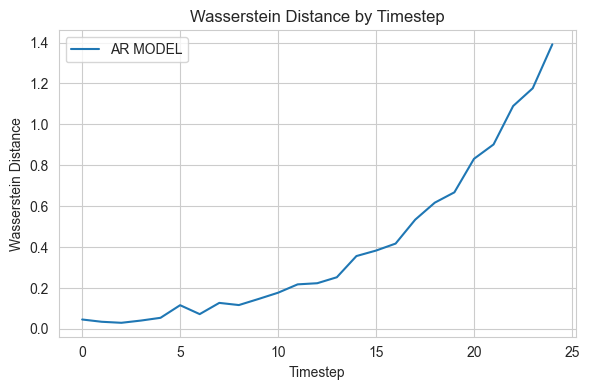

In [ ]:
wasserstein_dist_old(test_data[:,1:], supervised_data)